In [1]:
import os, sys, re, datetime, copy, shutil
import numpy as np
import astropy.units as u
import astropy.constants as const
from astropy.io import fits
from astropy.table import Table
from collections import OrderedDict
from scipy.optimize import curve_fit
from scipy.interpolate import griddata
sys.path.insert(1, os.path.join(os.path.dirname(os.getcwd()), 'utils'))
radex_calc_path = os.path.join(os.path.dirname(os.getcwd()), 'tmp', 'calc_radex_disky') # 'calc_radex'
LTE_calc_path = os.path.join(os.path.dirname(os.getcwd()), 'tmp', 'calc_LTE')

In [2]:
# User defined global parameters

# %run calc_NonLTE_RADEX_plot_R_CI10CO21_correction_matrix.ipynb

#list_of_N_CO = 10**np.arange(17.0, 20.0, 0.25) # n=ygrid
list_of_N_CO = 10**np.arange(17.00, 19.00+0.25, 0.25) # n=ygrid
#list_of_n_H2 = [1e2, 1e3, 1e4, 1e5, 1e6] # n=xgrid
list_of_n_H2 = [1e2, 3.16e2, 1e3, 3.16e3, 1e4, 3.16e4] # n=xgrid
list_of_T_kin = [15., 20., 25., 30., 50., 100.] # n=panel
#list_of_d_V_for_T_kin = [10., 10., 10., 10., 10., 10.] # n=panel -- use select_d_V instead
list_of_CO_abundance_for_T_kin = [1e-4, 1e-4, 1e-4, 1e-4, 1e-4, 1e-4] # n=panel

select_d_V = 10.0 # because we use N_CO/d_V, this has no effect

#select_X_CICO = 0.1
select_X_CICO = 0.2
#select_X_CICO = 1.0

if __name__ == '__main__' and '__file__' not in globals():

    out_fig_name = 'Plot_RADEX_R_CI10CO21_varied_CO_abundance_selected_RNCINCO_' + \
                   ('%.1f'%(select_X_CICO)).replace('.','p')

out_fig_size = (30, 4.0) # RADEX includes n_H2 = 1e2, so wider figure

out_fig_margin = {'left':0.05, 'right':0.96, 'bottom':0.18, 'top':0.88}

aspect = 0.433


In [3]:
# Define alphaCO function

def func_T_only(T_ex, a, b, c, d):
    """Adopted from "calc_LTE_alpha_CO_CI_new.ipynb" `func_alpha_T_only_approx`.
    """
    return (a + (T_ex/75.0)**b) * ((T_ex/75.0)**c) + d

def func_T_NLCorr_alphaCO10(T_kin, CO_abundance, N_CO_d_V = None, n_H2 = None):
    """Compute DZLIU T-NLCorr alpha conversion factor.
    
    The T-NLCorr approximation is combining the T-only approximation with a
    (N_CO/d_V) scaling. 
    
    The T-only approximation optimized parameters
    popt: [0.13176633022220194, 2.1207712219603527, -1.4961943803477826, -0.431324811483537]
    are fitted by the code "calc_LTE_alpha_CO_CI_new.ipynb".
    
    """
    popt = [0.13176633022220194, 2.1207712219603527, -1.4961943803477826, -0.431324811483537]
    val = func_T_only(T_kin, *popt) * (1e-4) / CO_abundance # T-only approximation
    # 0.525536 / ( 1.0 - np.exp( - (np.log10(n_H2) / 2.16907)**(2.37657) ) ) 
    # * ( N_CO_d_V / 5.77837e+16 )**( 1.0 - np.exp( -(72.9268 / T_kin)**(1.81294) ) )
    if N_CO_d_V is not None:
        val *= ( N_CO_d_V / 5.77837e+16 )**( 1.0 - np.exp( -(72.9268 / T_kin)**(1.81294) ) ) # T-prime approximate
    if n_H2 is not None:
        val *= 0.525536 / ( 1.0 - np.exp( - (np.log10(n_H2) / 2.16907)**(2.37657) ) ) # T-prime-NLCorr approximate
    return val



In [4]:
# Define functions to read the pre-calculated tables by "calc_NonLTE_RADEX_sim_XCICO.ipynb"

def format_lookup_key(X_CICO, d_V):
    if X_CICO < 0.1:
        X_CICO_str = '{:.2f}'.format(X_CICO)
    else:
        X_CICO_str = '{:.1f}'.format(X_CICO)
    if d_V < 0.1:
        d_V_str = '{:.2f}'.format(d_V)
    else:
        d_V_str = '{:.1f}'.format(d_V)
    return f'XCICO_{X_CICO_str}_dv_{d_V_str}kms'

def get_data_table_by_X_CICO_d_V(input_X_CICO, 
                                 input_d_V, 
                                 data_table_lookup_dict = None, 
                                 radex_calc_path = None, 
                                 check_T_kin_in_table = None
    ):
    # prepare lookup_key which is part of the data table file name
    lookup_key = format_lookup_key(input_X_CICO, input_d_V)
    print('lookup_key', lookup_key)
    # find data table file
    data_table = None
    if isinstance(data_table_lookup_dict, (dict, OrderedDict)):
        if lookup_key in data_table_lookup_dict:
            data_table = data_table_lookup_dict[lookup_key]
    if data_table is None:
        data_table_name = 'out_table_RADEX_R_CI10CO21_sim_' + lookup_key
        data_table_file = data_table_name + '.csv'
        if radex_calc_path is not None:
            data_table_file = os.path.join(radex_calc_path, 
                                           data_table_file)
        if not os.path.isfile(data_table_file):
            raise Exception('Error! File not found: "{}"! '.format(data_table_file) + 
                            'Run "calc_NonLTE_RADEX_sim_XCICO" first!')
        print('Reading "%s"'%(data_table_file))
        data_table = Table.read(data_table_file, format='csv')
        if isinstance(data_table_lookup_dict, (dict, OrderedDict)):
            data_table_lookup_dict[lookup_key] = data_table
    # check T_kin in table
    if check_T_kin_in_table is not None:
        if not isinstance(check_T_kin_in_table, (list, tuple)):
            check_T_kin_in_table = [check_T_kin_in_table]
        for T_kin in check_T_kin_in_table:
            uniq_T_kin = np.unique(data_table['T_kin'].data)
            if not np.any(np.isclose(T_kin, uniq_T_kin)):
                raise Exception('Error! T_kin {} not in table {}!'.format(T_kin, str(uniq_T_kin)))
    # return
    return data_table


In [5]:
# Define function to prepare the data arrays for the three figures

def read_data_tables_for_three_figures():
    global list_of_N_CO
    global list_of_n_H2
    global list_of_T_kin
    global list_of_CO_abundance_for_T_kin
    global select_X_CICO
    global select_d_V
    xpos_array = np.full([len(list_of_N_CO), len(list_of_n_H2)], fill_value=np.nan)
    ypos_array = np.full([len(list_of_N_CO), len(list_of_n_H2)], fill_value=np.nan)
    fig1_array = np.full([len(list_of_T_kin), len(list_of_N_CO), len(list_of_n_H2)], fill_value=np.nan)
    fig2_array = np.full([len(list_of_T_kin), len(list_of_N_CO), len(list_of_n_H2)], fill_value=np.nan)
    fig3_array = np.full([len(list_of_T_kin), len(list_of_N_CO), len(list_of_n_H2)], fill_value=np.nan)
    for iax, T_kin in enumerate(list_of_T_kin):
        #d_V = list_of_d_V_for_T_kin[iax]
        data_table = get_data_table_by_X_CICO_d_V(select_X_CICO, 
                                                  select_d_V, 
                                                  radex_calc_path = radex_calc_path, 
                                                  check_T_kin_in_table = T_kin, 
                                                 )
        for iy, N_CO in enumerate(list_of_N_CO):
            for ix, n_H2 in enumerate(list_of_n_H2):
                if iax == 0:
                    xpos_array[iy, ix] = np.log10(n_H2)
                    ypos_array[iy, ix] = np.log10(N_CO) - np.log10(select_d_V)
                irow = np.argwhere(np.logical_and.reduce((
                    np.isclose(np.log10(data_table['N_CO']), np.log10(N_CO)), 
                    np.isclose(np.log10(data_table['n_H2']), np.log10(n_H2)), 
                    np.isclose(data_table['T_kin'], T_kin), 
                ))).ravel()
                if len(irow) > 0:
                    irow = irow[0]
                else:
                    raise Exception('Data not found in table: N_CO {} n_H2 {} T_kin {} table {!r}'.format(
                        np.log10(N_CO), np.log10(n_H2), T_kin, 
                    ))
                # 
                R_CI10CO21_NonLTE = data_table['R_CI10CO21_NonLTE'][irow]
                R_CI10CO21_LTE = data_table['R_CI10CO21_LTE'][irow]
                fig1_array[iax, iy, ix] = R_CI10CO21_NonLTE
                fig2_array[iax, iy, ix] = R_CI10CO21_LTE
                fig3_array[iax, iy, ix] = R_CI10CO21_NonLTE/R_CI10CO21_LTE
    # 
    return xpos_array, ypos_array, fig1_array, fig2_array, fig3_array

# Read the data tables into the global variables

if __name__ == '__main__' and '__file__' not in globals():
    
    xpos_array, ypos_array, fig1_array, fig2_array, fig3_array = \
        read_data_tables_for_three_figures()
    
    print('xpos_array[0,:]', xpos_array[0,:])
    print('ypos_array[:,0]', ypos_array[:,0])


lookup_key XCICO_0.2_dv_10.0kms
Reading "/Users/dzliu/Work/2020_Liu_CO_CI/Excitation_Analysis/CICOExcitation/tmp/calc_radex_disky/out_table_RADEX_R_CI10CO21_sim_XCICO_0.2_dv_10.0kms.csv"
lookup_key XCICO_0.2_dv_10.0kms
Reading "/Users/dzliu/Work/2020_Liu_CO_CI/Excitation_Analysis/CICOExcitation/tmp/calc_radex_disky/out_table_RADEX_R_CI10CO21_sim_XCICO_0.2_dv_10.0kms.csv"
lookup_key XCICO_0.2_dv_10.0kms
Reading "/Users/dzliu/Work/2020_Liu_CO_CI/Excitation_Analysis/CICOExcitation/tmp/calc_radex_disky/out_table_RADEX_R_CI10CO21_sim_XCICO_0.2_dv_10.0kms.csv"
lookup_key XCICO_0.2_dv_10.0kms
Reading "/Users/dzliu/Work/2020_Liu_CO_CI/Excitation_Analysis/CICOExcitation/tmp/calc_radex_disky/out_table_RADEX_R_CI10CO21_sim_XCICO_0.2_dv_10.0kms.csv"
lookup_key XCICO_0.2_dv_10.0kms
Reading "/Users/dzliu/Work/2020_Liu_CO_CI/Excitation_Analysis/CICOExcitation/tmp/calc_radex_disky/out_table_RADEX_R_CI10CO21_sim_XCICO_0.2_dv_10.0kms.csv"
lookup_key XCICO_0.2_dv_10.0kms
Reading "/Users/dzliu/Work/2020_L

In [6]:
# Define function to plot one figure

import matplotlib
from matplotlib import pyplot as plt
from matplotlib import gridspec
from matplotlib import cm
from matplotlib import ticker
from matplotlib.patches import Rectangle, FancyBboxPatch

def add_fancy_box(axes, x, y, 
                  xy, 
                  width = 4, 
                  height = 3, 
    ):
    """
    Args: 
        `x` and `y` must be 2D arrays for the x y coordinates of each grid cell.
    """
    for iax in range(len(axes)):
        axes[iax].add_artist(FancyBboxPatch(xy=[np.argmin(np.abs(x[0,:]-xy[iax][0])),
                                                np.argmin(np.abs(y[:,0]-xy[iax][1]))], 
                                            width=width, height=height, boxstyle='round,pad=0.1',
                                            facecolor='none', edgecolor='k', lw=2))

def get_text_color_for_background_color(bkg_color):
    """
    See https://stackoverflow.com/questions/22603510/
        is-this-possible-to-detect-a-colour-is-a-light-or-dark-colour
    """
    r, g, b = bkg_color[0:3]
    hsp = np.sqrt(0.299 * (r * r) + 0.587 * (g * g) + 0.114 * (b * b))
    if (hsp < 1.2 * 127.5 / 255.0): # dark
        return 'w'
    else: # light
        return 'k'
    
def plot_one_figure(x, 
                    y, 
                    v,
                    vmin, 
                    vmax, 
                    vlog = True, 
                    vtext_format = '{:.2f}', 
                    vtext_fontsize = '14.5', # text in each cell, x-large
                    cellpad = 0.15,
                    colormap = None, 
                    colorbar_title = None, 
                    colorbar_title_format = None, 
                    colorbar_title_fontsize = '20', 
                    colorbar_title_pad = 10, 
                    colorbar_ticks = None, 
                    colorbar_tick_format = '%g', 
                    colorbar_labelsize = 'xx-large', 
                    aspect = 0.25, 
                    panel_titles = None, 
                    title_fontsize='20',
                    title_pad = 6,
                    xlabel = None, 
                    ylabel = None, 
                    xlabel_fontsize = '20', 
                    ylabel_fontsize = '20', 
                    xlabel_pad = 6, 
                    ylabel_pad = 18, 
                    xticklabel_format = '{:.2f}', 
                    yticklabel_format = '{:.2f}', 
                    ticklabelsize = 'x-large', 
                    topleft_text = None, 
                    topleft_text_fontsize = 'xx-large', 
                    topleft_text_xpos = -0.32, 
                    topleft_text_ypos = 1.028, 
                    rightmost_yfunc = None, 
                    rightmost_ylabel = None, 
                    rightmost_ylabel_fontsize = '20', 
                    rightmost_ylabel_pad = 5, 
                    rightmost_yticks = None, 
                    rightmost_yticklabel_format = '%g', 
                    rightmost_ylog = True, 
                    highlight_boxes = None, 
                    save_figure_file = None, 
    ):
    """
    Args: 
        `x` and `y` must be 2D arrays for the x y coordinates of each grid cell.
        `v` must be a 3D array, whose axis 0 dimension equals the panel number. 
        `vtext` means the small text printed inside each cell.
    """
    global out_fig_size
    global out_fig_margin
    
    npanel, ny, nx = v.shape
    
    if xlabel is None:
        xlabel = r'$\log_{10} \, n_{\mathrm{H_2}}$'
    if ylabel is None:
        #ylabel = r'$N_{\mathrm{CO}} \, / \, [\mathrm{cm^{-2}}]$'
        ylabel = r'$N_{\mathrm{CO}} \, / \, \Delta_{v}$'
    if rightmost_yfunc is None:
        #rightmost_yfunc = lambda t_log_N_CO: (10**t_log_N_CO / 1e-4 * 1.60141791e-20)
        rightmost_yfunc = lambda t_: (10**t_ / 1e-4 * 1.60141791e-20)
    if rightmost_ylabel is None:
        #rightmost_ylabel = r'$\Sigma_{\mathrm{H_2}} \, / \, [\mathrm{M_{\odot}\,pc^{-2}}]$'
        rightmost_ylabel = r'$\Sigma_{\mathrm{H_2}} \, / \, \Delta {v}$'
    if rightmost_yticks is None:
        #rightmost_yticks = np.array([10., 100., 1000., 10000.])
        rightmost_yticks = None
    if highlight_boxes is None:
        highlight_boxes = [(2.50, 16.75)]*npanel
    
    # create figure
    fig = plt.figure(figsize=out_fig_size)
    fig.subplots_adjust(**out_fig_margin)
    gs = gridspec.GridSpec(ncols=npanel+2, # +2 for color bar and a spacing
                           nrows=1, 
                           figure=fig, 
                           width_ratios=[1]*npanel+[0.28, 0.07], 
                           wspace=0.02, 
                           hspace=0)
    axes = []
    for i in range(npanel):
        ax = fig.add_subplot(gs[0, i])
        axes.append(ax)
    right_axes = []
    for iax in range(npanel):
        axes[iax].set_xlabel(xlabel, fontsize=xlabel_fontsize, labelpad=xlabel_pad)
        #axes[iax].set_xlim([0, nx])
        axes[iax].set_xlim([0-cellpad, nx+cellpad])
        axes[iax].set_xticks(np.arange(nx)+0.5)
        axes[iax].set_xticklabels([xticklabel_format.format(x[0,t]) for t in range(nx)])
        #axes[iax].set_ylim([0, ny])
        axes[iax].set_ylim([0-cellpad, ny+cellpad])
        axes[iax].set_yticks(np.arange(ny)+0.5)
        if iax == 0: 
            axes[iax].set_ylabel(ylabel, fontsize=ylabel_fontsize, labelpad=ylabel_pad)
            axes[iax].set_yticklabels([yticklabel_format.format(y[t,0]) for t in range(ny)])
        else:
            axes[iax].set_yticklabels([])
        if ticklabelsize is not None:
            axes[iax].tick_params(labelsize=ticklabelsize)
        axes[iax].set_aspect(aspect)
        if panel_titles is not None:
            axes[iax].set_title(panel_titles[iax], fontsize=title_fontsize, pad=title_pad) # panel title
        right_axes.append(axes[iax].twinx())
        if ticklabelsize is not None:
            right_axes[iax].tick_params(labelsize=ticklabelsize)
        right_axes[iax].set_aspect(aspect)
        right_axes[iax].set_yticks(np.arange(ny)+0.5)
        right_axes[iax].set_yticklabels([])
        right_axes[iax].set_ylim(axes[iax].get_ylim())
    
    if vlog:
        colornorm = matplotlib.colors.LogNorm(vmin=vmin, vmax=vmax, clip=True)
    else:
        colornorm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax, clip=True)
    if colormap is None:
        colormap = cm.RdBu_r # cm.jet # cm.viridis # cm.RdYlBu_r
    colormapper = cm.ScalarMappable(norm=colornorm, cmap=colormap)
    
    ax_colorbar = fig.add_subplot(gs[0, -1])
    if colorbar_title is not None:
        ax_colorbar.set_title(colorbar_title, 
                              fontsize=colorbar_title_fontsize, 
                              pad=colorbar_title_pad)
    if colorbar_labelsize is not None:
        ax_colorbar.tick_params(labelsize=colorbar_labelsize)
    cbar = fig.colorbar(mappable=colormapper, 
                        cax=ax_colorbar)
    if colorbar_ticks is not None:
        cbar.set_ticks(colorbar_ticks)
    if colorbar_tick_format is not None:
        cbar.ax.yaxis.set_major_formatter(ticker.FormatStrFormatter(colorbar_tick_format))
    cbar.ax.yaxis.set_minor_formatter(ticker.NullFormatter())
    cbar.ax.yaxis.set_minor_locator(ticker.LogLocator())

    for iax in range(npanel):
        for iy in range(ny):
            for ix in range(nx):
                ax = axes[iax]
                val = v[iax, iy, ix]
                color = colormapper.to_rgba(val)
                ax.fill_between([ix, ix+1], [iy, iy], [iy+1, iy+1], 
                                color = color, 
                                alpha = 1.0, 
                                lw = 0.0)
                text_color = get_text_color_for_background_color(color)
                ax.text(ix+0.5, iy+0.5, vtext_format.format(val), 
                        ha='center', va='center', color=text_color, fontsize=vtext_fontsize)

    # show topleft text
    ax = axes[0]
    if topleft_text is not None:
        ax.text(topleft_text_xpos, topleft_text_ypos, topleft_text, 
                ha='left', va='bottom', fontsize=topleft_text_fontsize, transform=ax.transAxes)

    # add a rightmost y axis
    ax = axes[-1]
    axRight = right_axes[-1]
    if rightmost_yfunc is not None:
        axRight.set_aspect('auto')
        print('axRight y[0,0]', y[0,0], 'y[-1,0]', y[-1,0])
        ylim1 = rightmost_yfunc(y[0,0])
        ylim2 = rightmost_yfunc(y[-1,0])
        print('axRight ylim', ylim1, ylim2)
        if rightmost_ylog:
            ylim1 = np.log10(ylim1)
            ylim2 = np.log10(ylim2)
            axRight.set_yscale('log')
            print('axRight ylim', ylim1, ylim2, 'in log')
        ylim = np.array([ylim1-(ylim2-ylim1)*0.5/float(ny-1),
                         ylim2+(ylim2-ylim1)*0.5/float(ny-1)]
                       ) # from pix [0.5, ny-0.5] to [0, ny]
        print('axRight ylim', ylim)
        if rightmost_ylog:
            ylim = 10**ylim
            print('axRight ylim', ylim, 'in linear')
        if rightmost_yticks is not None:
            axRight.set_yticks(rightmost_yticks)
            print('axRight set_yticks', rightmost_yticks) # set ticks before set ylim
        axRight.set_ylim(ylim)
        print('axRight set_ylim', ylim)
        print('axRight get_ylim', axRight.get_ylim())
        if rightmost_yticklabel_format is not None:
            axRight.yaxis.set_major_formatter(ticker.FormatStrFormatter(rightmost_yticklabel_format))
        if rightmost_ylabel is not None:
            axRight.set_ylabel(rightmost_ylabel, 
                               fontsize=rightmost_ylabel_fontsize, 
                               labelpad=rightmost_ylabel_pad)

    # add a highlighting box in each panel
    if highlight_boxes is not None:
        add_fancy_box(axes, x, y, highlight_boxes)

    # save fig
    if save_figure_file is not None:
        print(f"Output to {save_figure_file!r}")
        fig.savefig(save_figure_file, dpi=300)
    
    # return fig
    return fig


axRight y[0,0] 16.0 y[-1,0] 18.0
axRight ylim 1.6014179100000001 160.141791
axRight ylim 0.2045046812778552 2.204504681277855 in log
axRight ylim [0.07950468 2.32950468]
axRight ylim [  1.20089402 213.55251048] in linear
axRight set_ylim [  1.20089402 213.55251048]
axRight get_ylim (1.200894017430284, 213.55251048351965)
Output to 'Plot_RADEX_R_CI10CO21_varied_CO_abundance_selected_RNCINCO_0p2_LTE.pdf'


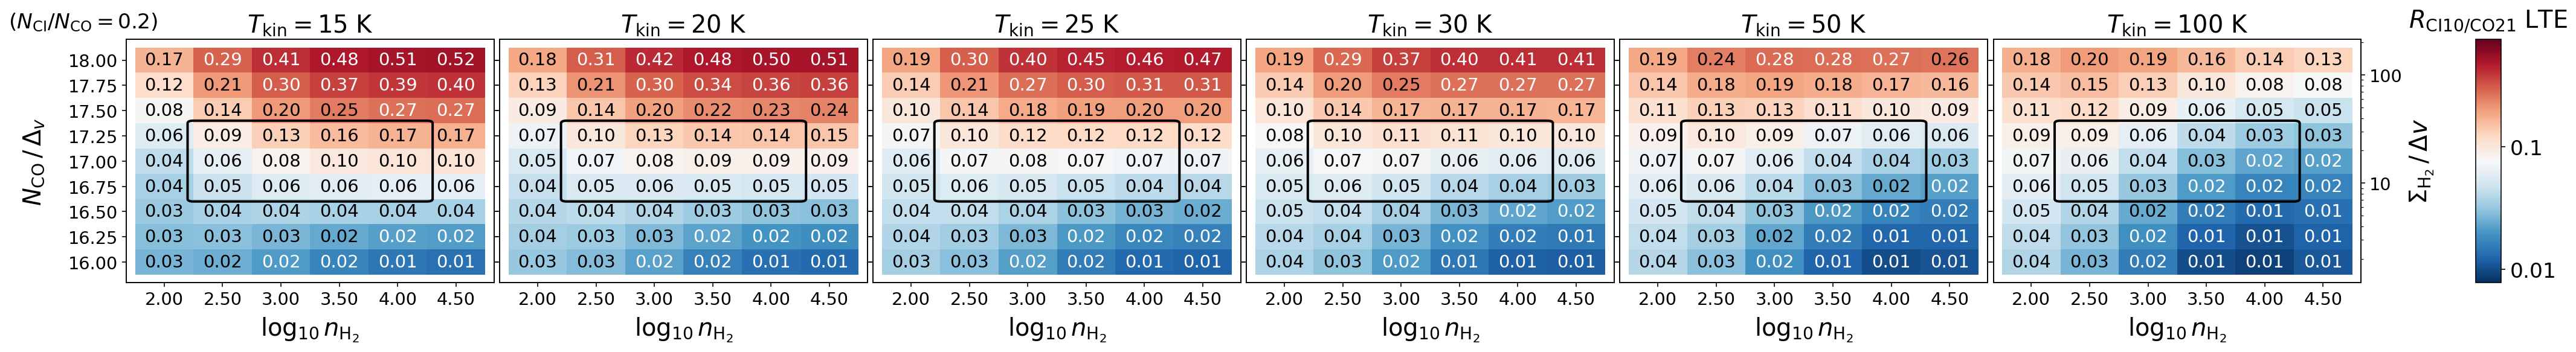

In [7]:
# Make fig1

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

if __name__ == '__main__' and '__file__' not in globals():
    
    #panel_titles = []
    #for i in range(len(list_of_T_kin)):
    #    T_kin = list_of_T_kin[i]
    #    d_V = list_of_d_V_for_T_kin[i]
    #    T_kin_str = '%.0f'%(T_kin)
    #    d_V_str = '%.0f'%(d_V)
    #    CO_abundance = list_of_CO_abundance_for_T_kin[i]
    #    CO_abundance_str = '{:g}e{:g}'.format(CO_abundance/10**np.floor(np.log10(CO_abundance)), 
    #                                          np.floor(np.log10(CO_abundance)))
    #    panel_title = f'T_kin = {T_kin_str} K,' + '\n' + \
    #                  f'd_V = {d_V_str} km/s' + '\n' + \
    #                  r'($[{\mathrm{CO}}/{\mathrm{H_2}}]={\tt{%s}})$'%(CO_abundance_str)
    #    panel_titles.append(panel_title)
    
    panel_titles = [r'$T_{\mathrm{kin}} = ' + '%.0f'%(T_kin) + '$ K' for T_kin in list_of_T_kin]
    
    colorbar_title = r'$R_{\mathrm{CI10}/\mathrm{CO21}}$' + ' ' + \
                     r'$\mathrm{LTE}$'
    
    colorbar_ticks = None # [0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
    
    topleft_text = r'($N_{\mathrm{CI}}/N_{\mathrm{CO}} = %.1f)$'%(select_X_CICO)

    fig1 = plot_one_figure(
        xpos_array, 
        ypos_array, 
        fig1_array, 
        vmin = 0.00780, 
        vmax = 0.75, 
        aspect = aspect, 
        panel_titles = panel_titles, 
        colorbar_title = colorbar_title, 
        colorbar_ticks = colorbar_ticks, 
        topleft_text = topleft_text, 
        save_figure_file = out_fig_name + '_LTE.pdf', 
    )

axRight y[0,0] 16.0 y[-1,0] 18.0
axRight ylim 1.6014179100000001 160.141791
axRight ylim 0.2045046812778552 2.204504681277855 in log
axRight ylim [0.07950468 2.32950468]
axRight ylim [  1.20089402 213.55251048] in linear
axRight set_ylim [  1.20089402 213.55251048]
axRight get_ylim (1.200894017430284, 213.55251048351965)
Output to 'Plot_RADEX_R_CI10CO21_varied_CO_abundance_selected_RNCINCO_0p2_NonLTE.pdf'


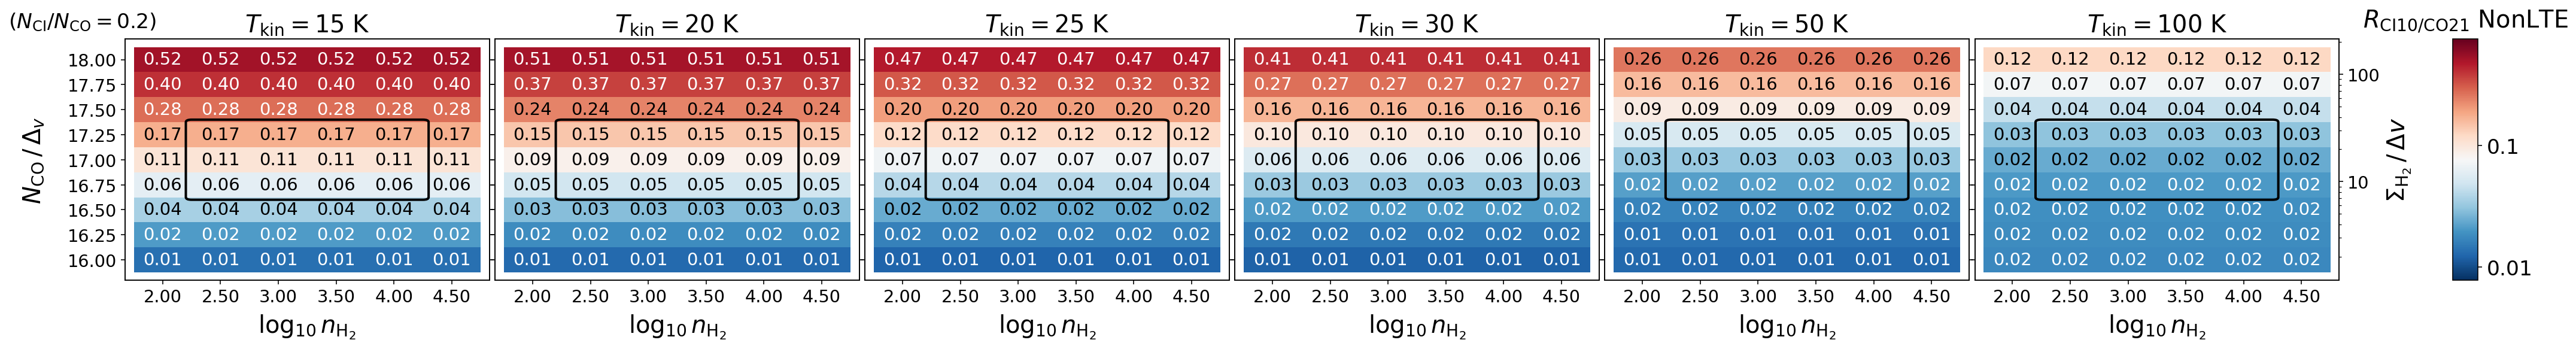

In [8]:
# Make fig2

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

if __name__ == '__main__' and '__file__' not in globals():
    
    colorbar_title = r'$R_{\mathrm{CI10}/\mathrm{CO21}}$' + ' ' + \
                     r'$\mathrm{NonLTE}$'
    
    colorbar_ticks = None # [0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]

    fig2 = plot_one_figure(
        xpos_array, 
        ypos_array, 
        fig2_array, 
        vmin = 0.00780, 
        vmax = 0.75, 
        aspect = aspect, 
        panel_titles = panel_titles, 
        colorbar_title = colorbar_title, 
        colorbar_ticks = colorbar_ticks, 
        topleft_text = topleft_text, 
        save_figure_file = out_fig_name + '_NonLTE.pdf', 
    )

axRight y[0,0] 16.0 y[-1,0] 18.0
axRight ylim 1.6014179100000001 160.141791
axRight ylim 0.2045046812778552 2.204504681277855 in log
axRight ylim [0.07950468 2.32950468]
axRight ylim [  1.20089402 213.55251048] in linear
axRight set_ylim [  1.20089402 213.55251048]
axRight get_ylim (1.200894017430284, 213.55251048351965)
Output to 'Plot_RADEX_R_CI10CO21_varied_CO_abundance_selected_RNCINCO_0p2_R_NLCorr.pdf'


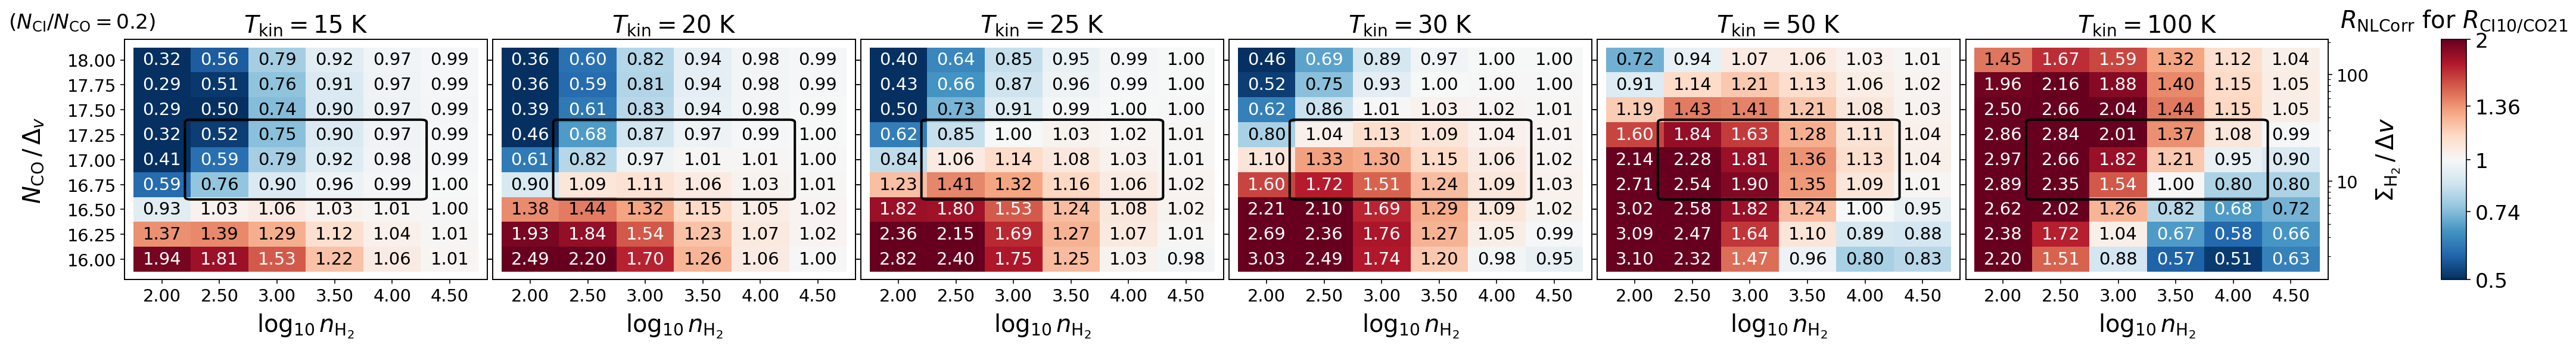

In [13]:
# Make fig3

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

if __name__ == '__main__' and '__file__' not in globals():
    
    colorbar_title = r'$R_{\mathrm{NLCorr}}$ for $R_{\mathrm{CI10}/\mathrm{CO21}}$'
    
    colorbar_ticks = [0.5, 0.74, 1.0, 1.36, 2.0]

    fig3 = plot_one_figure(
        xpos_array, 
        ypos_array, 
        fig3_array, 
        vmin = 0.5, 
        vmax = 2.0, 
        aspect = aspect, 
        panel_titles = panel_titles, 
        colorbar_title = colorbar_title, 
        colorbar_ticks = colorbar_ticks, 
        topleft_text = topleft_text, 
        save_figure_file = out_fig_name + '_R_NLCorr.pdf', 
    )


In [10]:
# Define function to save NLCorr matrix to file for later scipy gridddata

def save_NLCorr_matrix_to_file(
        x_array, y_array, z_array, data_array, out_NLCorr_matrix_file, 
        x_type = 'log10 n_H2', 
        y_type = 'log10 N_CO/d_V', 
        z_type = 'T_kin', 
        data_type = 'R_NLCorr',
    ):
    # 
    npanel, ny, nx = data_array.shape
    zmesh, ymesh, xmesh = np.meshgrid(z_array, y_array, x_array, indexing='ij')
    data = data_array
    # 
    #out_NLCorr_matrix_file = 'out_NLCorr_matrix_alphaCO21.fits'
    if os.path.isfile(out_NLCorr_matrix_file):
        shutil.move(out_NLCorr_matrix_file, out_NLCorr_matrix_file + '.backup')
    header = fits.Header()
    header['NAXIS'] = 3
    header['NAXIS1'] = nx
    header['NAXIS2'] = ny
    header['NAXIS3'] = npanel
    header['OBJECT'] = data_type
    header['CTYPE1'] = x_type
    header['CTYPE2'] = y_type
    header['CTYPE3'] = z_type
    header['CUNIT1'] = 'cm^-3'
    header['CUNIT2'] = 'cm^-2 km^-1 s'
    header['CUNIT3'] = 'K'
    header['CDELT1'] = x_array[1] - x_array[0]
    header['CDELT2'] = y_array[1] - y_array[0]
    header['CDELT3'] = 1.0 # non-uniform grid
    hdu = fits.PrimaryHDU(data = data, header = header)
    header2 = fits.Header()
    header2['OBJECT'] = 'point-value array for griddata interp'
    data2 = Table(OrderedDict([(x_type, xmesh.ravel()), 
                               (y_type, ymesh.ravel()), 
                               (z_type, zmesh.ravel()), 
                               (data_type, data.ravel())]))
    hdu2 = fits.BinTableHDU(data = data2, header = header2)
    hdulist = fits.HDUList([hdu, hdu2])
    hdulist.writeto(out_NLCorr_matrix_file)
    print('Output to {!r}'.format(out_NLCorr_matrix_file))

def interpolate_NLCorr(n_H2, N_X_d_V, T_kin, NLCorr_matrix_file):
    log_n_H2 = np.log10(n_H2)
    log_N_X_d_V = np.log10(N_X_d_V)
    NLCorr_table = fits.getdata(NLCorr_matrix_file, 1) # BinTable is in extension
    x = NLCorr_table.field(0) # log n_H2
    y = NLCorr_table.field(1) # log N_X_d_V
    z = NLCorr_table.field(2)
    data = NLCorr_table.field(3)
    points = np.column_stack([x, y, z])
    interp_vals = griddata(points, data, (log_n_H2, log_N_X_d_V, T_kin), method='linear')
    return interp_vals


In [17]:
# Define function to fit and plot NLCorr curve

def func_NLCorr_hybrid(xxx, a, b, c, d, e, g):
    nn, mm, tt = xxx # log_n_H2, log_N_CO_d_V, T_kin
    return a / ( 1.0 - np.exp( - (nn / b)**(c) ) ) * ( (10**mm / d)**(1.0 - np.exp(-(e/tt)**g)) )

def str_func_NLCorr_hybrid(a, b, c, d, e, g):
    str_func = '{:g} / ( 1.0 - np.exp( - (np.log10(n_H2) / {:g})**({:g}) ) ) ' \
               '* ( N_CO_d_V / {:g} )**( 1.0 - np.exp( -({:g} / T_kin)**({:g}) ) )'.format(a, b, c, d, e, g)
    return str_func

def latex_str_func_NLCorr_hybrid(a, b, c, d, e, g):
    latex_str = r'${:.2f} / \left( 1 - \exp\left[ - (log_n_H2 / {:.2f})^{{{:.2f}}} \right] \right)'\
        .format(a, b, c)
    latex_str += r' \; \times \; '
    latex_str += r'(N_CO_d_V/{:.2e})^{{\left( 1 - \exp\left[ -({:.2f} / T_kin)^{{{:.2f}}} \right] \right)}}$'\
        .format(d, e, g)
    latex_str = latex_str.replace('N_CO_d_V', r'N_{\mathrm{CO}}/{\Delta v}')
    latex_str = latex_str.replace('log_n_H2', r'\log n_{\mathrm{H_2}}')
    latex_str = latex_str.replace('T_kin', r'T_{\mathrm{kin}}')
    latex_str = latex_str.replace('e+', 'e')
    latex_str = latex_str.replace('*', r'\,')
    latex_str = latex_str.replace('/', r'\,/\,')
    return latex_str

def fit_func_NLCorr_hybrid(xxx, y):
    popt, pcov = curve_fit(func_NLCorr_hybrid, xxx, y, p0=[10.0, 3.2, 3.2, 1.0e17, 75., 1.0])
    yfit = func_NLCorr_hybrid(xxx, *popt)
    return popt, yfit

# TRYING 20220406 14h NOT HELPFUL
# def func_NLCorr_hybrid(xxx, a, b, c, d, e, g):
#     nn, mm, tt = xxx # log_n_H2, log_N_CO_d_V, T_kin
#     nn = nn
#     mm = 10**mm / 2e17 # linearly scales with N_CO_d_V
#     tt = 1.0 - np.exp(-75.0/tt) # starts from about 1.0, decreases to 0.0 with T_kin
#     emm = 1.0 - np.exp(-mm**(e)) # starts from 0.0, increases to 1.0 with N_CO_d_V if e>0
#     gmm = 1.0 - np.exp(-mm**(g)) # starts from 0.0, increases to 1.0 with N_CO_d_V if e>0
#     #return a * (nn**(b-emm) + nn**(c+gmm)) * ( mm**tt / (1.0-np.exp(-mm**(d))))
#     return a * (b*np.exp(-nn) + c*nn) * ( mm**tt / (1.0-np.exp(-mm**(d))))

# def str_func_NLCorr_hybrid(a, b, c, d, e, g):
#     str_func = '{:g} / ( 1.0 - np.exp( - (np.log10(n_H2) / {:g})**({:g}) ) ) ' \
#                '* ( N_CO_d_V / {:g} )**( 1.0 - np.exp( -({:g} / T_kin)**({:g}) ) )'.format(a, b, c, d, e, g)
#     return str_func

# def latex_str_func_NLCorr_hybrid(a, b, c, d, e, g):
#     latex_str = r'${:.2f} / \left( 1 - \exp\left[ - (log_n_H2 / {:.2f})^{{{:.2f}}} \right] \right)'\
#         .format(a, b, c)
#     latex_str += r' \; \times \; '
#     latex_str += r'(N_CO_d_V/{:e})^{{\left( 1 - \exp\left[ -({:g} / T_kin)^{{{:g}}} \right] \right)}}$'\
#         .format(d, e, g)
#     latex_str = latex_str.replace('N_CO_d_V', r'N_{\mathrm{CO}}/{\Delta v}')
#     latex_str = latex_str.replace('log_n_H2', r'\log n_{\mathrm{H_2}}')
#     latex_str = latex_str.replace('T_kin', r'T_{\mathrm{kin}}')
#     latex_str = latex_str.replace('*', r'\,')
#     latex_str = latex_str.replace('/', r'\,/\,')
#     return latex_str

# def fit_func_NLCorr_hybrid(xxx, y):
#     popt, pcov = curve_fit(func_NLCorr_hybrid, xxx, y, p0=[1.0, 1.0, 0.2, 0.5, 0.5, 0.1])
#     yfit = func_NLCorr_hybrid(xxx, *popt)
#     return popt, yfit

# 

def func_NLCorr(x, a, b, c):
    return a / ( 1.0 - np.exp( - (x / b)**(c) ) )

def str_func_NLCorr(a, b, c):
    str_func = '{:g} / ( 1.0 - np.exp( - (np.log10(n_H2) / {:g})**({:g}) ) )'.format(a, b, c)
    return str_func

def fit_func_NLCorr(x, y):
    popt, pcov = curve_fit(func_NLCorr, x, y, p0=[10.0, 3.2, 3.2])
    yfit = func_NLCorr(x, *popt)
    return popt, yfit

def plot_curve_fit(
        x_array, # log n_H2
        y_array, # log NX_dV
        z_array, # T_kin
        data_array, 
        out_fig_name, 
        x_type = 'log n_H2', # for FITS header CTYPE1
        y_type = 'log N_CO/d_V', # for FITS header CTYPE2
        z_type = 'T_kin', # for FITS header CTYPE3
        datalim = None, 
        panel_titles = None, 
        title_fontsize='20',
        title_pad = 6,
        xlabel = r'$\log n_{\mathrm{H_2}}$', # for plotting
        ylabel = r'$R_{\mathrm{NLCorr}}$', # for plotting
        xlabel_fontsize = '20', 
        ylabel_fontsize = '20', 
        xlabel_pad = 6, 
        ylabel_pad = 18, 
        xticklabel_format = '%.1f', 
        yticklabel_format = '%.1f', 
        ticklabelsize = 'x-large', 
        colorbar_title = None, 
        colorbar_title_fontsize = '20', 
        colorbar_title_pad = 20, 
        colorbar_ticks = None, 
        colorbar_tick_format = None, 
        colorbar_labelsize = 'xx-large', 
        do_curve_fit_levels = [0], # 1 for each NCOdV, 2 for each Tkin, 3 for all-hybrid.
        color_for_curve_fit_levels = None, 
    ):
    # 
    global list_of_T_kin
    global out_fig_size
    global out_fig_margin
    # 
    npanel, ny, nx = data_array.shape
    # 
    # create figure
    #fig = plt.figure(figsize=(20, 2.5))
    # 
    # create figure
    fig = plt.figure(figsize=out_fig_size)
    fig.subplots_adjust(**out_fig_margin)
    gs = gridspec.GridSpec(ncols=npanel+2, # +2 for color bar and a spacing
                           nrows=1, 
                           figure=fig, 
                           width_ratios=[1]*npanel+[0.28, 0.07], 
                           wspace=0.02, 
                           hspace=0)
    axes = []
    for i in range(npanel):
        ax = fig.add_subplot(gs[0, i])
        axes.append(ax)
    # 
    # add colorbar
    vmin, vmax = np.min(y_array), np.max(y_array)
    colornorm = matplotlib.colors.LogNorm(vmin=vmin, vmax=vmax, clip=True)
    colormap = cm.jet # cm.jet # cm.viridis # cm.RdYlBu_r
    colormapper = cm.ScalarMappable(norm=colornorm, cmap=colormap)
    
    ax_colorbar = fig.add_subplot(gs[0, -1])
    if colorbar_title is not None:
        ax_colorbar.set_title(colorbar_title, 
                              fontsize=colorbar_title_fontsize, 
                              pad=colorbar_title_pad)
    if colorbar_labelsize is not None:
        ax_colorbar.tick_params(labelsize=colorbar_labelsize)
    cbar = fig.colorbar(mappable=colormapper, 
                        cax=ax_colorbar)
    if colorbar_ticks is not None:
        cbar.set_ticks(colorbar_ticks)
    if colorbar_tick_format is not None:
        cbar.ax.yaxis.set_major_formatter(ticker.FormatStrFormatter(colorbar_tick_format))
    else:
        cbar.ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
    cbar.ax.yaxis.set_major_locator(ticker.MultipleLocator(0.25))
    cbar.ax.yaxis.set_minor_formatter(ticker.NullFormatter())
    # 
    if datalim is None:
        datalim = [np.min(data_array) * 0.8, np.max(data_array) * 1.2]
    #axes = []
    points = [] # xxx
    values = [] # yyy
    colors = []
    fitted_curve_fit_popts = {}
    for ipanel in range(npanel):
        #ax = fig.add_subplot(1, npanel, ipanel+1)
        ax = axes[ipanel]
        ax.tick_params(which='both', labelsize=ticklabelsize, right=True)
        ax.set_yscale('log')
        ax.yaxis.set_major_formatter(ticker.FormatStrFormatter(yticklabel_format))
        ax.yaxis.set_major_locator(ticker.LogLocator(base=10, subs=(1,2,3,4,5,)))
        ax.yaxis.set_minor_formatter(ticker.NullFormatter())
        ax.xaxis.set_major_formatter(ticker.FormatStrFormatter(xticklabel_format))
        ax.xaxis.set_major_locator(ticker.MultipleLocator(0.5))
        ax.set_ylim(datalim)
        ax.set_xlabel(xlabel, fontsize=xlabel_fontsize, labelpad=xlabel_pad)
        if panel_titles is not None:
            ax.set_title(panel_titles[ipanel], fontsize=title_fontsize, pad=title_pad) # panel title
        if ipanel == 0:
            ax.set_ylabel(ylabel, fontsize=ylabel_fontsize, labelpad=ylabel_pad)
        else:
            ax.set_yticklabels([])
        if ipanel == npanel-1:
            ax_right = ax.twinx()
            ax_right.tick_params(labelsize=ticklabelsize)
            ax_right.set_yscale('log')
            ax_right.yaxis.set_major_formatter(ticker.FormatStrFormatter(yticklabel_format))
            ax_right.yaxis.set_major_locator(ticker.LogLocator(base=10, subs=(1,2,3,4,5,)))
            ax_right.yaxis.set_minor_formatter(ticker.NullFormatter())
            ax_right.set_ylim(datalim)

        data_row_list = []
        for iy in range(ny):
            data_row = data_array[ipanel, iy, :]
            data_row_list.append(data_row)
            for ix in range(nx):
                points.append([x_array[ix], y_array[iy], z_array[ipanel]])
                values.append(data_row[ix])
            if do_curve_fit_levels.count(0) > 0:
                linestyle = 'dotted'
            else:
                linestyle = 'none'
            color = colormapper.to_rgba(y_array[iy])
            plotobj = ax.plot(x_array, data_row, ls=linestyle, marker='x', color=color, alpha=0.8)
            colors.append(plotobj[0].get_color())
            # 
            if do_curve_fit_levels.count(1) > 0:
                popt, data_fit = fit_func_NLCorr(x_array, data_row)
                ax.plot(x_array, data_fit, ls='dashed', alpha=0.8)
                print('fitted NLCorr formula: ' + str_func_NLCorr(*popt) + \
                      ', ' + z_type + ' = ' + '{:g}'.format(z_array[ipanel]) + \
                      ', ' + y_type + ' = ' + '{:.2e}'.format(y_array[iy])
                     )
                fitted_curve_fit_popts['1'] = copy.copy(popt)
            # 
        if do_curve_fit_levels.count(2) > 0:
            data_row_mean = np.mean(data_row_list, axis=0)
            popt, data_fit = fit_func_NLCorr(x_array, data_row_mean)
            ax.plot(x_array, data_fit, ls='solid')
            print('fitted NLCorr formula: ' + str_func_NLCorr(*popt) + \
                      ', ' + z_type + ' = ' + '{:g}'.format(z_array[ipanel])
                 )
            fitted_curve_fit_popts['2'] = copy.copy(popt)
            #print('fitted NLCorr popt: [' + ', '.join([str(t) for t in popt]) + ']')
        ax.grid(True, ls='dotted', color='gray', alpha=0.6, lw=0.3)
    # 
    if do_curve_fit_levels.count(3) > 0:
        points = np.array(points).astype(float).T
        values = np.array(values).astype(float)
        #print('points.shape', points.shape)
        #print('values.shape', values.shape)
        #print('points.T[0:10]', points.T[0:10])
        #print('values[0:10]', values[0:10])
        popt, data_fit = fit_func_NLCorr_hybrid(points, values)
        print('fitted NLCorr hybrid formula: ' + str_func_NLCorr_hybrid(*popt))
        print('fitted NLCorr hybrid popt: [' + ', '.join([str(t) for t in popt]) + ']')
        data_fit = data_fit.reshape([npanel, ny, nx])
        #print('data_fit.shape', data_fit.shape)
        for ipanel in range(npanel):
            for iy in range(ny):
                color = colors[ipanel*ny+iy]
                if color_for_curve_fit_levels is not None:
                    if 3 in color_for_curve_fit_levels:
                        color = color_for_curve_fit_levels[3]
                    if '3' in color_for_curve_fit_levels:
                        color = color_for_curve_fit_levels['3']
                axes[ipanel].plot(x_array, 
                                  data_fit[ipanel, iy, :],
                                  color = color, 
                                  ls = 'solid', 
                                  lw = 2.0, 
                                  alpha = 0.5, 
                                 )
                #print('data_fit[ipanel, iy, :]', data_fit[ipanel, iy, :])
        fitted_curve_fit_popts['3'] = copy.copy(popt)
        # 
        ax = axes[0]
        ax.text(0.0, 1.0, 'NLCorr = ' + latex_str_func_NLCorr_hybrid(*popt), ha='left', va='bottom', 
                transform=ax.transAxes, fontsize='20') # TODO
    # 
    #fig.tight_layout()
    fig.savefig(out_fig_name + '_R_NLCorr_curve_fit.pdf', dpi=300)
    print('Output to {!r}'.format(out_fig_name + '_R_NLCorr_curve_fit.pdf'))
    #display(fig)
    # 
    return fitted_curve_fit_popts


Output to 'out_NLCorr_matrix_R_CI10CO21.fits'


/Users/dzliu/Software/CONDA/miniconda3/envs/condapy37/lib/python3.7/site-packages/ipykernel_launcher.py:196: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


Output to 'Plot_RADEX_R_CI10CO21_varied_CO_abundance_selected_RNCINCO_0p2_R_NLCorr_curve_fit.pdf'


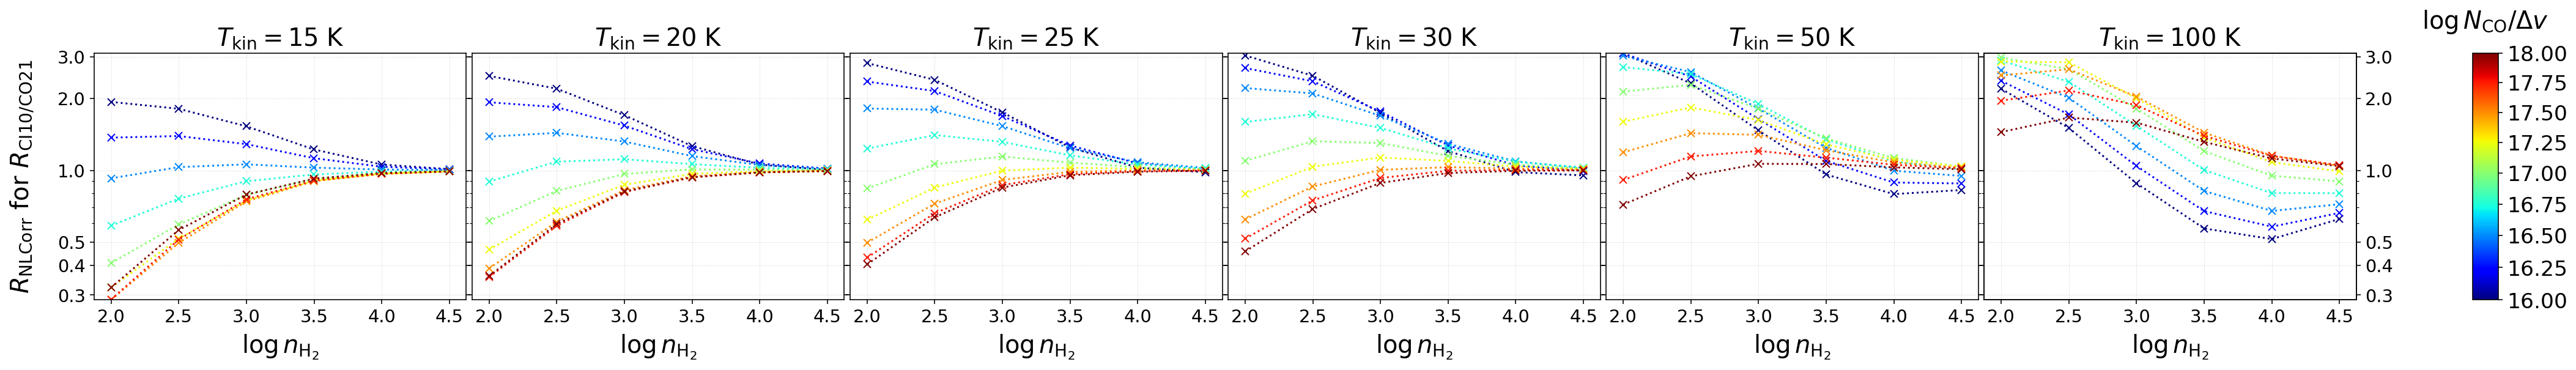

In [15]:
# Save NLCorr matrix to file and plot curve fit

if __name__ == '__main__' and '__file__' not in globals():
    
    out_NLCorr_matrix_file = 'out_NLCorr_matrix_R_CI10CO21.fits'
    save_NLCorr_matrix_to_file(
        x_array = xpos_array[0,:], 
        y_array = ypos_array[:,0], 
        z_array = np.array(list_of_T_kin), 
        data_array = fig3_array, 
        out_NLCorr_matrix_file = out_NLCorr_matrix_file,
    )
    
    plot_curve_fit(
        x_array = xpos_array[0,:], 
        y_array = ypos_array[:,0], 
        z_array = np.array(list_of_T_kin), 
        data_array = fig3_array, 
        out_fig_name = out_fig_name, 
        panel_titles = panel_titles, 
        ylabel = r'$R_{\mathrm{NLCorr}}$ for $R_{\mathrm{CI10}/\mathrm{CO21}}$', 
        colorbar_title = r'$\log N_{\mathrm{CO}}/{\Delta v}$', 
        do_curve_fit_levels = [0],
    )
